Author: Sasank Chilamkurthy

In this tutorial, you will learn how to train a convolutional neural network for image classification using transfer learning. You can read more about the transfer learning at [cs231n](https://cs231n.github.io/transfer-learning/) notes

> 
> In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.
> 

These two major transfer learning scenarios look as follows:

- **Finetuning the convnet**: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

- **ConvNet as fixed feature extractor**: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [3]:

plt.ion()   # interactive mode

## 加载数据
我们将使用**torchvision**和**torch.utils.data**包来加载数据。

我们今天要解决的问题是训练一个模型来对蚂蚁和蜜蜂进行分类。 我们为蚂蚁和蜜蜂提供了大约 120 张训练图像。 每个类别有 75 个验证图像。 通常，如果从头开始训练的话，这是一个非常小的数据集。 由于我们正在使用迁移学习，因此我们应该能够很好地概括。

该数据集是 **imagenet** 的很小一部分。

注意

从的下载数据，并将其提取到当前目录。

> Download the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it to the current directory.

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
device

device(type='cuda', index=0)

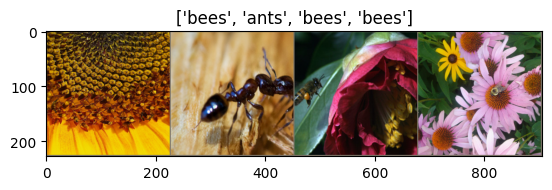

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


## 训练模型
现在，让我们编写一个通用函数来训练模型。 在这里，我们将说明：

- 安排学习率
- 保存最佳模型

以下，参数scheduler是来自**torch.optim.lr_scheduler**的 LR 调度器对象。

In [8]:
def train_model(model:torch.nn.Module, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# 可视化模型预测
通用函数，显示一些图像的预测#

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# 微调 ConvNet
加载预训练的模型并重置最终的全连接层。

In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


C:\Users\user\.conda\envs\machine-learning\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\.conda\envs\machine-learning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss: 0.7507 Acc: 0.6680
val Loss: 0.2375 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4114 Acc: 0.8238
val Loss: 0.3750 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.4832 Acc: 0.7869
val Loss: 0.2763 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.6099 Acc: 0.7623
val Loss: 0.1976 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4146 Acc: 0.8484
val Loss: 0.3154 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.6480 Acc: 0.7746
val Loss: 0.9475 Acc: 0.7255

Epoch 6/24
----------
train Loss: 0.7882 Acc: 0.7254
val Loss: 0.2824 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3652 Acc: 0.8689
val Loss: 0.2337 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3097 Acc: 0.8689
val Loss: 0.2121 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3858 Acc: 0.8607
val Loss: 0.2095 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2864 Acc: 0.8811
val Loss: 0.2494 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2935 Acc: 0.8770
val Loss: 0.2218 Acc: 0.9281

Ep

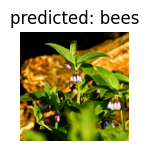

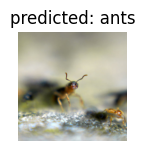

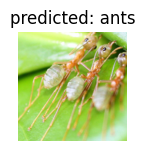

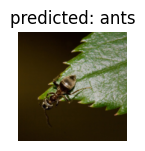

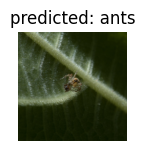

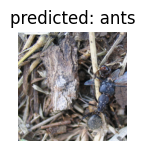

In [13]:
visualize_model(model_ft)


## 作为固定特征提取器的 ConvNet
在这里，我们需要冻结除最后一层之外的所有网络。 我们需要设置**requires_grad == False**冻结参数，以便不在 **backward()** 中计算梯度。

[您可以在文档中阅读有关此内容的更多信息。](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)

In [14]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.6928 Acc: 0.6885
val Loss: 0.2001 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4945 Acc: 0.7582
val Loss: 0.2028 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4088 Acc: 0.7992
val Loss: 0.2230 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.4196 Acc: 0.8156
val Loss: 0.1841 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.6635 Acc: 0.7418
val Loss: 0.2996 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.5046 Acc: 0.7869
val Loss: 0.1756 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.4199 Acc: 0.8115
val Loss: 0.1967 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3243 Acc: 0.8320
val Loss: 0.1922 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3913 Acc: 0.8156
val Loss: 0.1926 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3131 Acc: 0.8934
val Loss: 0.1885 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4027 Acc: 0.8156
val Loss: 0.2087 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3339 Acc: 0.8566
val Loss: 0.2059 Acc: 0.9346

Ep

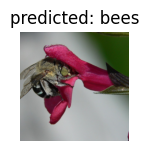

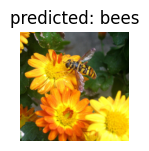

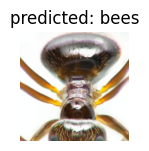

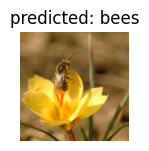

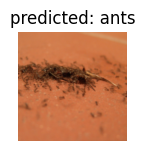

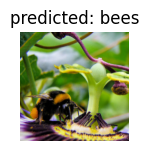

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()
